# Task 1.1(Segment Bones)
Goals:
* Need to find and separate the femur and tibia bones from the CT scan using image processing methods.
* Save my result in `.nii.gz` format (a format used for medical images).

In [ ]:
%pip install nibabel opencv-python scikit-image matplotlib numpy

### Load the CT scan

In [ ]:
import nibabel as nib
import numpy as np

# loading file
image_path = "/content/3702_left_knee.nii.gz"
ct_image = nib.load(image_path)
ct_data = ct_image.get_fdata()

print("CT image shape:", ct_data.shape)


CT image shape: (512, 512, 216)


### Visualize Some Slices

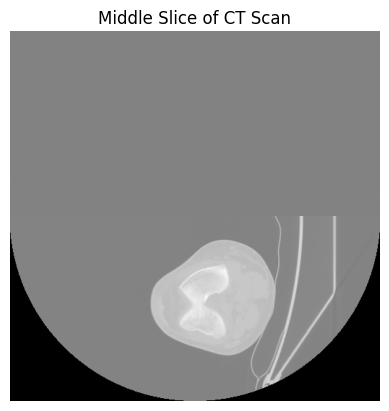

In [ ]:
import matplotlib.pyplot as plt

# View a middle slice
slice_index = ct_data.shape[2] // 2
plt.imshow(ct_data[:, :, slice_index], cmap='gray')
plt.title("Middle Slice of CT Scan")
plt.axis('off')
plt.show()

### Apply Image Processing for Bone Segmentation

In [ ]:
# Simple thresholding to separate bones
bone_mask = ct_data > 300  # 300 is a common threshold for bone

# Converting boolean to integer mask
bone_mask = bone_mask.astype(np.uint8)

### Save the Segmentation Mask

In [ ]:
seg_mask_img = nib.Nifti1Image(bone_mask, ct_image.affine)
nib.save(seg_mask_img, "output/bone_mask.nii.gz")

### Output Image Result

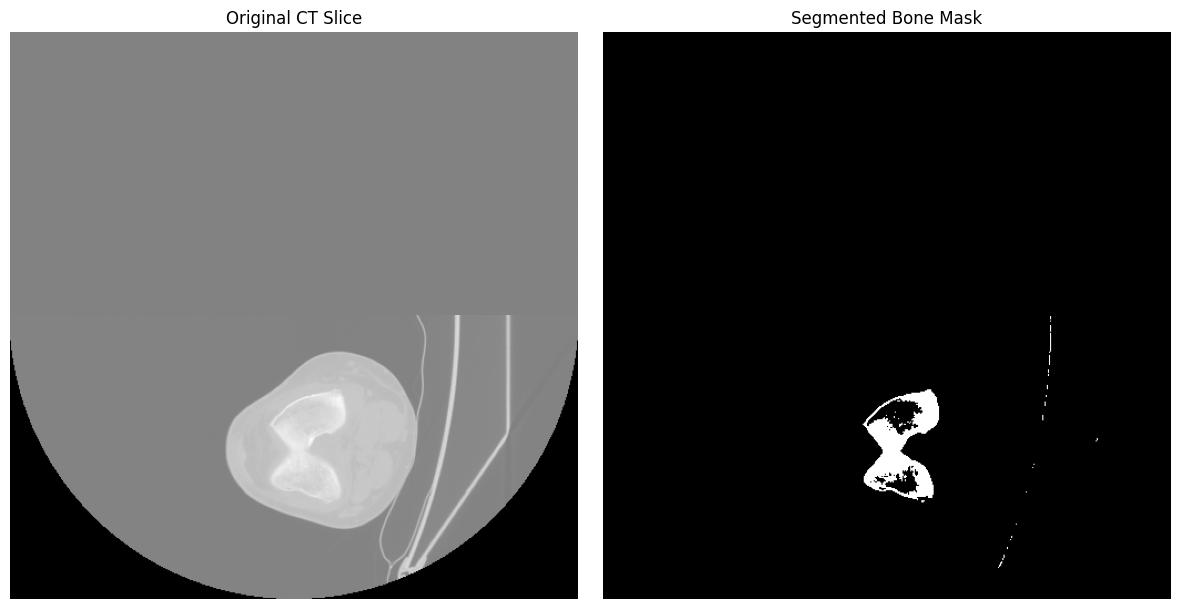

In [ ]:
# Plot original CT and segmented bone mask side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original CT slice
axes[0].imshow(ct_data[:, :, slice_index], cmap='gray')
axes[0].set_title('Original CT Slice')
axes[0].axis('off')

# Segmented bone mask slice
axes[1].imshow(bone_mask[:, :, slice_index], cmap='gray')
axes[1].set_title('Segmented Bone Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()


# Task 1.2

After creating a bone mask in Task 1.1 (where bone = 1 and everything else = 0), then I need to:
* thicken of the edge (boundary) of the bone mask outward by 2 mm — for example, thickening the area of the bone slightly all the way around.

This is also known as a `morphological dilation` (in image processing).

###  Load the bone mask created in Task 1.1

In [ ]:
bone_mask_img = nib.load("/content/bone_mask (1).nii.gz")
bone_mask = bone_mask_img.get_fdata()
affine = bone_mask_img.affine

###  Understand voxel size (real-world mm size)

In [ ]:
voxel_spacing = bone_mask_img.header.get_zooms()
print("Voxel size (mm):", voxel_spacing)

Voxel size (mm): (np.float32(0.869141), np.float32(0.869141), np.float32(2.0))


###   Calculate how many pixels = 2 mm

* modify `[ceil(4/v)]` for 4mm dilation

In [ ]:
from math import ceil

# Convert 2 mm into voxel units (number of pixels)
expand_voxels = [ceil(2/ v) for v in voxel_spacing]
print("Expand by this many voxels:", expand_voxels)

Expand by this many voxels: [3, 3, 1]


### Apply Morphological Dilation

In [ ]:
from scipy.ndimage import binary_dilation

# Apply 3D dilation
expanded_mask = binary_dilation(bone_mask, structure=np.ones(expand_voxels)).astype(np.uint8)

### Save the expanded mask

In [ ]:
expanded_img = nib.Nifti1Image(expanded_mask, affine)
nib.save(expanded_img, "output/bone_mask_2mm_expanded.nii.gz")

### Compare Original vs Expanded Bone Mask

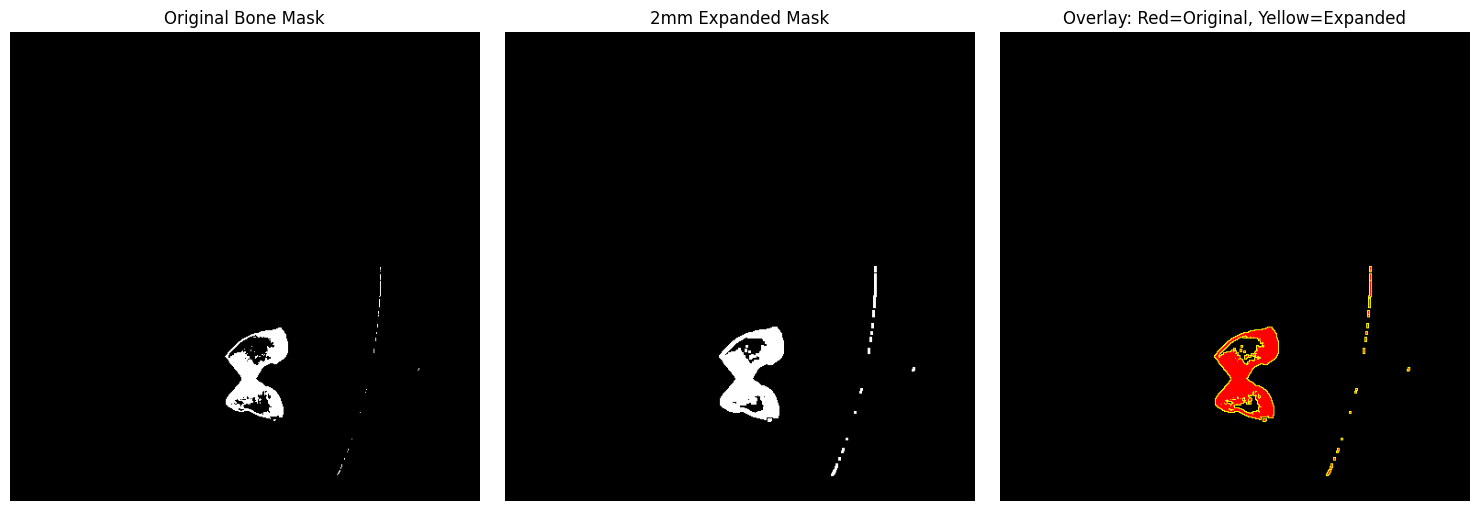

In [ ]:
# Prepare plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original bone mask
axes[0].imshow(bone_mask[:, :, slice_index], cmap='gray')
axes[0].set_title("Original Bone Mask")
axes[0].axis('off')

# Expanded bone mask
axes[1].imshow(expanded_mask[:, :, slice_index], cmap='gray')
axes[1].set_title("2mm Expanded Mask")
axes[1].axis('off')

# Overlay (create RGB image)
original = bone_mask[:, :, slice_index] == 1
expanded = expanded_mask[:, :, slice_index] == 1

# Create empty RGB image
overlay_rgb = np.zeros((*original.shape, 3), dtype=np.uint8)

# Red channel: original only
overlay_rgb[original] = [255, 0, 0]  # red

# Yellow = red + green → for expanded area only
overlay_rgb[expanded & ~original] = [255, 255, 0]  # yellow

axes[2].imshow(overlay_rgb)
axes[2].set_title("Overlay: Red=Original, Yellow=Expanded")
axes[2].axis('off')

plt.tight_layout()
plt.show()

### Making sure the Expansion

In [ ]:
diff_mask = expanded_mask - bone_mask
diff_mask

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [ ]:
print(np.unique(diff_mask))

[0. 1.]


In [ ]:
print("Original mask sum:", np.sum(bone_mask))
print("Expanded mask sum:", np.sum(expanded_mask))

Original mask sum: 299151.0
Expanded mask sum: 506352
